# Imports and data read in 

In [15]:
from pat_tools import feat_and_lab_alspac, feat_and_lab_mcs, plot_conmat, make_conmat, impute_features, screen_time_split, FeatureGroup
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [8]:
# Create feature group objects, these make it easier to keep features/conmat/description of features together
alspac_screen = FeatureGroup("Data.csv", "ALSPAC", "Screen time features")
alspac_noscreen = FeatureGroup("Data.csv", "ALSPAC", "Non screen time features")
mcs_screen = FeatureGroup("MCS_data.csv", "MCS", "Screen time features")
mcs_noscreen = FeatureGroup("MCS_data.csv", "MCS", "Non screen time features")
feature_groups = [alspac_screen, alspac_noscreen, mcs_screen, mcs_noscreen]

# Get the features and labels out for each dataset (ALSPAC and MCS)
alspac_data = "Data.csv"
alspac_features, alspac_label = feat_and_lab_alspac(alspac_data, balance=True)
mcs_data = "MCS_data.csv"
mcs_features, mcs_label = feat_and_lab_mcs(mcs_data, balance=True)

alspac_screen.label = alspac_label
alspac_noscreen.label = alspac_label
mcs_screen.label = mcs_label
mcs_noscreen.label = mcs_label

In [19]:
mcs_dataset = pd.read_csv(mcs_data)

print(len(mcs_dataset))

mcs_dataset['DocDep17'].value_counts(dropna=False)

7460


1.0    6607
2.0     721
NaN     132
Name: DocDep17, dtype: int64

# Analysis

## Split features into screen-time/non screen-time

In [9]:
# Impute missing features
alspac_features = impute_features(alspac_features)
mcs_features = impute_features(mcs_features)

# Split features into screen-time/non screen-time
alspac_screen.features, alspac_noscreen.features = screen_time_split(alspac_features, "ALSPAC")
mcs_screen.features, mcs_noscreen.features = screen_time_split(mcs_features, "MCS")


## Decision tree

In [10]:
# Variables to set
max_tree_depth = 6
split_criterion = 'gini'
splitter = 'best'


# Make a decision tree for each feature group and get the confusion matrix on the test set
for feature_group in feature_groups:
    # K fold 
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    # Create Decision Tree classifer object
    #clf = DecisionTreeClassifier(criterion=split_criterion, class_weight='balanced', 
    #                             max_depth=max_tree_depth, splitter=splitter)
    
    # Random forest 
    clf = RandomForestClassifier(max_depth=max_tree_depth)

    # Cross validation
    scores = cross_validate(clf, feature_group.features, feature_group.label, cv=cv, return_train_score=True)
    y_pred = cross_val_predict(clf, feature_group.features, feature_group.label, cv=cv)

    # Save the tree and make a confusion matrix
    feature_group.tree = clf 
    feature_group.conmat = make_conmat(y_pred, feature_group.label)
    print(scores['train_score'], scores['test_score'])

    # Fit for plotting the tree
    clf.fit(feature_group.features, feature_group.label)
    importances = dict(zip(feature_group.features.columns, clf.feature_importances_))
    print(len(importances), dict(sorted(importances.items(), key=lambda item: item[1], reverse=True)))

[0.88028169 0.86619718 0.88732394 0.86013986 0.87412587] [0.47222222 0.5        0.44444444 0.51428571 0.57142857]
9 {'tv': 0.16760226428591773, 'text': 0.14291993341237963, 'phone': 0.13300549325763425, 'fam_tv': 0.12746118224707273, 'computer': 0.11436028349548699, 'talk_mob': 0.10214659578740566, 'comp_games_bed': 0.08174530054474916, 'tv_bed_9': 0.06818859406893135, 'talk_phone': 0.0625703529004225}
[0.97183099 0.98591549 0.99295775 0.99300699 0.96503497] [0.47222222 0.55555556 0.44444444 0.48571429 0.42857143]
21 {'mat_dep': 0.14671014159370027, 'iq': 0.13438458649662766, 'mat_age': 0.12027406219994198, 'agg_score': 0.07794703630886811, 'alone': 0.06383514582873277, 'exercise': 0.05778909092481003, 'read': 0.053310854285472095, 'outside_win': 0.05050571177100809, 'work': 0.04486567336341326, 'outside_sum': 0.03130038615166856, 'draw': 0.027847814413208296, 'music': 0.02570011725936763, 'pat_pres_8': 0.02278875507770868, 'play': 0.022202672381250753, 'pat_pres_10': 0.021458744345253

0.47738821138211385 0.47560975609756095 0.4773074961754207 0.4764571137694069
0.47745694022289764 0.4787234042553192 0.47751389590702376 0.47811788515051856
0.5425225659317213 0.5369211514392991 0.5430043361552757 0.5399456106076767
0.628461499364676 0.6432 0.6247832629637383 0.6338578851569097


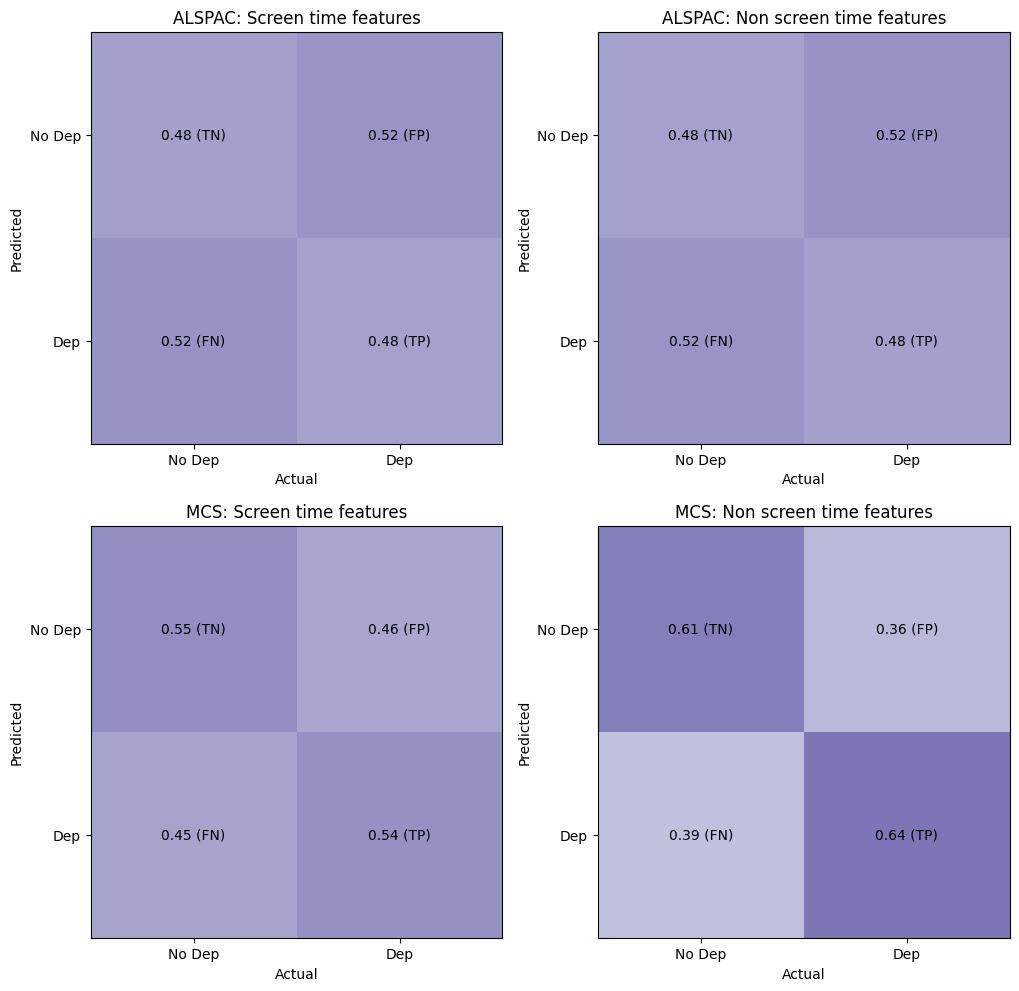

In [11]:
fig, ax = plt.subplots(2,2,figsize=(12,12), dpi=100)

for i, feature_group in enumerate(feature_groups):
    # Print metrics 
    (tn, fp,fn,tp) = feature_group.conmat.flatten()
    accuracy = (tn+tp)/(tn+fp+tp+fn)
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f_1 = 2*((precision*recall)/(precision+recall))
    print(accuracy,precision,recall,f_1)
    if i < 2:
        ax[0,i] = plot_conmat(feature_group.conmat, ax[0,i])
        ax[0,i].set(title = feature_group.study + ": " + feature_group.description)
    else:
        ax[1,i-2] = plot_conmat(feature_group.conmat, ax[1,i-2])
        ax[1,i-2].set(title = feature_group.study + ": " + feature_group.description)

plt.show()

In [12]:
"""

fig, ax = plt.subplots(2,2,figsize=(12,12), dpi=500)

for i, feature_group in enumerate(feature_groups):
    if i < 2:
        plot_tree(feature_group.tree, ax = ax[0,i], feature_names=feature_group.features.columns, class_names=['No Dep', 'Dep'])
        ax[0,i].set(title = feature_group.study + ": " + feature_group.description)
    else:
        plot_tree(feature_group.tree, ax = ax[1,i-2], feature_names=feature_group.features.columns, class_names=['No Dep', 'Dep'])
        ax[1,i-2].set(title = feature_group.study + ": " + feature_group.description)

plt.show()

"""

'\n\nfig, ax = plt.subplots(2,2,figsize=(12,12), dpi=500)\n\nfor i, feature_group in enumerate(feature_groups):\n    if i < 2:\n        plot_tree(feature_group.tree, ax = ax[0,i], feature_names=feature_group.features.columns, class_names=[\'No Dep\', \'Dep\'])\n        ax[0,i].set(title = feature_group.study + ": " + feature_group.description)\n    else:\n        plot_tree(feature_group.tree, ax = ax[1,i-2], feature_names=feature_group.features.columns, class_names=[\'No Dep\', \'Dep\'])\n        ax[1,i-2].set(title = feature_group.study + ": " + feature_group.description)\n\nplt.show()\n\n'